In [1]:
# load packages 
%matplotlib inline
import os
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import geopandas as gpd
import pyproj
import shapely.geometry
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import numpy as np
import xarray as xr
import rioxarray as rxr
from geocube.api.core import make_geocube
import xesmf as xe
import cartopy.crs as ccrs
import contextily as ctx

# imports for rasterizing 
import geopandas as gpd
import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
import xwrf

# dask
import dask
from dask.distributed import Client, LocalCluster

In [2]:
# import US Census Urban Area vector file
home_path = Path('/home1/kojoseph/anthropogenic-heat-la-20230205')
data_path = home_path / 'data'
filepath = data_path / 'boundaries/2016_urban_area.geojson'
urban = gpd.read_file(filepath)
# import la county boundary
filename = data_path / 'boundaries/la_county_bound_simplified.gpkg'
la_county = gpd.read_file(filename)
# urban areas in la county
urban = urban.to_crs(la_county.crs)
urban_la_county = urban.overlay(la_county)
# urban_la_county.plot()

/home1/kojoseph/.conda/envs/geo_env_clone/lib/python3.9/site-packages/geopandas/tools/overlay.py:299: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[mask, col] = df.loc[mask, col].buffer(0)


In [3]:
# test read wrfout file
test_folder = '/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test/JOE_Default_08_ah=2_GDAS_frac_urb/wrfout_d02*'
print(f'test folder: {test_folder}')
filelist = glob.glob(test_folder)
ds = xr.open_mfdataset(filelist, 
                    engine="netcdf4",
                    concat_dim="Time",
                    combine="nested").xwrf.postprocess()
ds

test folder: /project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test/JOE_Default_08_ah=2_GDAS_frac_urb/wrfout_d02*


<xarray.Dataset>
Dimensions:                    (Time: 217, y: 192, x: 244, z: 44,
                                urban_wind_directions_stag: 4, z_stag: 45)
Coordinates:
    XLAT                       (y, x) float32 dask.array<chunksize=(192, 244), meta=np.ndarray>
    XLONG                      (y, x) float32 dask.array<chunksize=(192, 244), meta=np.ndarray>
    XTIME                      (Time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * Time                       (Time) datetime64[ns] 2016-08-10 ... 2016-08-19
  * x                          (x) float64 1.325e+05 1.335e+05 ... 3.755e+05
  * y                          (y) float64 -4.254e+05 -4.244e+05 ... -2.344e+05
Dimensions without coordinates: z, urban_wind_directions_stag, z_stag
Data variables: (12/99)
    Times                      (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    Q2                         (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    T2                         (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    PSFC                       (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    U10                        (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    ...                         ...
    LANDMASK                   (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    LAKEMASK                   (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    SST                        (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    SST_INPUT                  (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    air_potential_temperature  (Time, z, y, x) float32 dask.array<chunksize=(1, 44, 192, 244), meta=np.ndarray>
    wrf_projection             object +proj=lcc +x_0=0 +y_0=0 +a=6370000 +b=6...
Attributes: (12/136)
    TITLE:                            OUTPUT FROM WRF V4.6.0 MODEL
    START_DATE:                      2016-08-10_00:00:00
    SIMULATION_START_DATE:           2016-08-10_00:00:00
    WEST-EAST_GRID_DIMENSION:        245
    SOUTH-NORTH_GRID_DIMENSION:      193
    BOTTOM-TOP_GRID_DIMENSION:       45
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

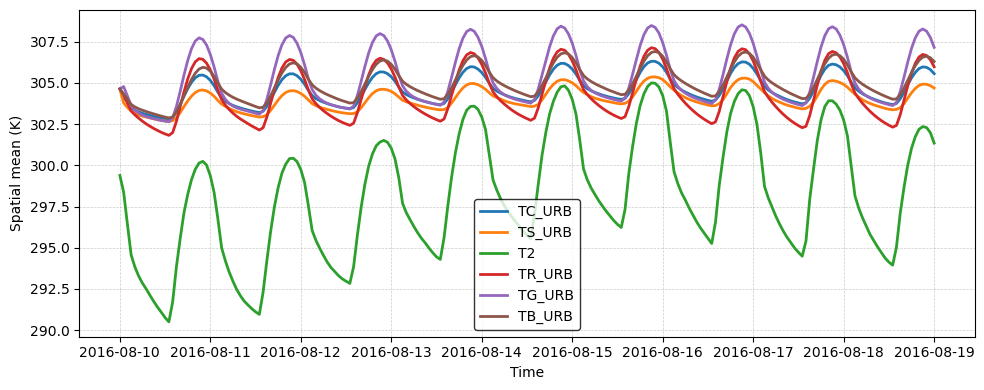

In [ ]:
# compute spatially averaged time series and plot on white background
import numpy as np
import matplotlib.pyplot as plt

vars_to_plot = ["TC_URB", "TS_URB", "T2", "TR_URB", "TG_URB", "TB_URB"]


# choose a distinguishable palette (tab10 has high contrast colors)
cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in range(len(vars_to_plot))]

# compute spatial mean for each variable (average over all dims except Time)
ts = {}
for v in vars_to_plot:
    if v not in ds:
        raise KeyError(f"{v} not found in dataset")
    da = ds[v]
    spatial_dims = [d for d in da.dims if d.lower() != "time"]
    ts[v] = da.mean(dim=spatial_dims).load()

fig, ax = plt.subplots(figsize=(10,4))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

for i, v in enumerate(vars_to_plot):
    ax.plot(time, ts[v].values, label=v, color=colors[i], linewidth=2)


ax.set_xlabel("Time", color="black")
ax.set_ylabel("Spatial mean (K)", color="black")
ax.grid(True, linewidth=0.5, linestyle="--", color="gray", alpha=0.4)
ax.tick_params(colors="black")

leg = ax.legend(frameon=True)
leg.get_frame().set_facecolor("white")
leg.get_frame().set_edgecolor("black")
for text in leg.get_texts():
    text.set_color("black")

plt.tight_layout()
plt.show()

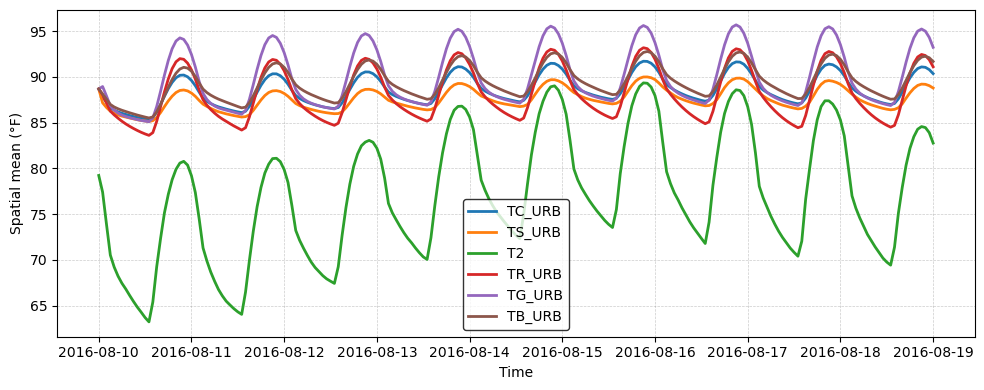

In [12]:
# Same plot in degF 
vars_to_plot = ["TC_URB", "TS_URB", "T2", "TR_URB", "TG_URB", "TB_URB"]

# choose a distinguishable palette (tab10 has high contrast colors)
cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in range(len(vars_to_plot))]

# compute spatial mean for each variable (average over all dims except Time)
ts = {}
for v in vars_to_plot:
    if v not in ds:
        raise KeyError(f"{v} not found in dataset")
    da = ds[v]
    spatial_dims = [d for d in da.dims if d.lower() != "time"]
    ts[v] = da.mean(dim=spatial_dims).load()

# helper: Kelvin -> Fahrenheit
def k_to_f(x):
    return (x - 273.15) * 9.0/5.0 + 32.0

fig, ax = plt.subplots(figsize=(10,4))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

for i, v in enumerate(vars_to_plot):
    # convert to °F before plotting
    y = k_to_f(ts[v])
    ax.plot(time, y.values, label=v, color=colors[i], linewidth=2)

ax.set_xlabel("Time", color="black")
ax.set_ylabel("Spatial mean (°F)", color="black")
ax.grid(True, linewidth=0.5, linestyle="--", color="gray", alpha=0.4)
ax.tick_params(colors="black")

leg = ax.legend(frameon=True)
leg.get_frame().set_facecolor("white")
leg.get_frame().set_edgecolor("black")
for text in leg.get_texts():
    text.set_color("black")

plt.tight_layout()
plt.show()